In [6]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import scipy
import os
import random
import gc
from keras.callbacks import ModelCheckpoint
from zipfile import ZipFile
import glob
from tensorflow.keras.applications.resnet50 import preprocess_input


In [7]:
data = pd.read_csv('/com.docker.devenvironments.code/fer2013/icml_face_data.csv')

In [8]:
pixel_data = data[' pixels']
label_data = data['emotion']

In [9]:
len(label_data)

35887

In [10]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)

  X = np.array(images)
  return X



In [11]:
oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

In [12]:
X_over_series = pd.Series(X_over.flatten())
X_over_series

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    113 114 115 122 88 69 134 175 178 175 179 178 ...
62919    198 180 103 128 142 103 93 84 90 98 126 152 20...
62920    196 131 139 142 144 145 147 149 150 151 150 12...
62921    154 155 155 155 155 154 155 153 156 152 98 31 ...
62922    31 31 27 26 28 30 24 24 25 29 32 29 25 22 21 2...
Length: 62923, dtype: object

In [13]:
X = preprocess_pixels(X_over_series)
Y = Y_over

In [14]:
Y = Y_over.values.reshape(Y.shape[0],1)
Y.shape

(62923, 1)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 45)
print(X_train.shape, Y_train.shape)

(56630, 48, 48, 1) (56630, 1)


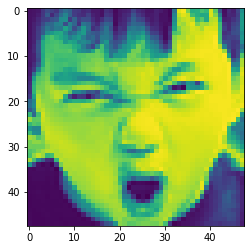

In [16]:
plt.imshow(X[25000,:,:,0])

In [17]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3), include_top=False, weights='imagenet')
def emotion_recognition(input_shape):
  
  X_input = Input(input_shape)

  X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid')(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'same')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)


  X = MaxPooling2D((2,2))(X)

  X = Conv2D(128, (3,3), strides=(1,1), padding = 'valid')(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)

 

  X = MaxPooling2D((2,2))(X)
  X = Flatten()(X)
  X = Dense(200, activation='relu')(X)
  X = Dropout(0.6)(X)
  X = Dense(7, activation = 'softmax')(X)
  
  model = Model(inputs=X_input, outputs=X)
  model = model.add(base_model)

  return model

In [18]:
model = emotion_recognition((48,48,1))
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.load_weights('/com.docker.devenvironments.code/Checkpoints/cp.ckpt')
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

AttributeError: 'Functional' object has no attribute 'add'

In [ ]:
y_train = to_categorical(Y_train, num_classes=7)
y_test = to_categorical(Y_test, num_classes=7)


In [ ]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}


In [ ]:
preds = model.predict(X_train)
def get_class(preds):
  pred_class = np.zeros((preds.shape[0],1))

  for i in range(len(preds)):
   pred_class[i] = np.argmax(preds[i])

  return pred_class

pred_class_train = get_class(preds)

In [ ]:
# DO NOT RUN AGAIN AS SAVED TRAINING CHECKPOINT IS LOADED

#checkpoint_path = "/com.docker.devenvironments.code/Checkpoints/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

#model.fit(X_train, y_train, epochs = 30, validation_data=(X_test,y_test), callbacks=[cp_callback])

In [ ]:
test_image_count = len(os.listdir('/com.docker.devenvironments.code/fer2013/RandomImages'))
print('There are ' + str(test_image_count) + ' images in the testing folder')

test_image = random.choice(os.listdir('/com.docker.devenvironments.code/fer2013/RandomImages'))

img_path = ('/com.docker.devenvironments.code/fer2013/RandomImages/' + test_image)
#img_path2 = ('/com.docker.devenvironments.code/fer2013/RandomImages/')
img = image.load_img(img_path, grayscale=True, target_size=(48,48,1))
#img_new = str(img_path2)
'''i = 0
for file in os.listdir(img_path2):
    filename = os.fsdecode(file)
    img_new = os.path.join(img_path2, filename)
    img2 = image.load_img(img_new, grayscale=True, target_size=(48,48,1))
    x = image.img_to_array(img2)
    x = np.expand_dims(x, axis=0)
    prediction = np.argmax(model.predict(x))
    print('The predicted emotion is : ' + label_dict[prediction])
    my_image = image.load_img(img_new)
    plt.imshow(my_image)
    i = i + 1
    
print (i)'''


x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

prediction = np.argmax(model.predict(x))
print('The predicted emotion is : ' + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)

